<a href="https://colab.research.google.com/github/mannam95/Deep_Learning_Programming/blob/main/Assignment5/Assignment_5_RNN_Part1_Srinath.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Team Assignment


1.   Srinath Mannam (229750)
2.   Meghana Rao (234907)
3.   Govind Shukla (235192)

# import statements

In [1]:
import os
import tensorflow as tf
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
import sys
import tensorflow.keras.backend as K
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import pydot
import graphviz
from keras.callbacks import ModelCheckpoint
from datetime import datetime
from keras.preprocessing import sequence

# Change the directory

In [2]:
working_directory = '/content/drive/My Drive/Colab Notebooks/OVGU/Deep_Learning/05_Assignment'
def colabDrive():
    from google.colab import drive
    drive.mount("/content/drive")

    if os.getcwd() !=  working_directory:
      os.chdir(working_directory)
    print(os.getcwd())

In [3]:
#colabDrive()

# Clears GPU memory

In [235]:
def clearGPUMemory():
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()
    !nvidia-smi

In [ ]:
#clearGPUMemory()

# Prepare the data

## Load the dataset and remove infrequent words

In [2]:
num_words = 20000
(train_sequences, train_labels), (test_sequences, test_labels) = tf.keras.datasets.imdb.load_data(num_words=num_words)

print('Loaded dataset with {} training samples, {} test samples'.format(len(train_sequences), len(test_sequences)))

17473536/17464789 [==============================] - 0s 0us/step
Loaded dataset with 25000 training samples, 25000 test samples


## Have some look at train dataset

In [3]:
# look at some sequences. words have been replaced with arbitrary index mappings
# 1 is a special "beginning of sequence" marker
# infrequent words have been replaced by the index 2
# actual words start with index 4, 3 is never used (???)
train_sequences[:3]

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 82

In [4]:
print('---review---')
print(train_sequences[6])
print('---label---')
print(train_labels[6])

---review---
[1, 6740, 365, 1234, 5, 1156, 354, 11, 14, 5327, 6638, 7, 1016, 10626, 5940, 356, 44, 4, 1349, 500, 746, 5, 200, 4, 4132, 11, 16393, 9363, 1117, 1831, 7485, 5, 4831, 26, 6, 2, 4183, 17, 369, 37, 215, 1345, 143, 2, 5, 1838, 8, 1974, 15, 36, 119, 257, 85, 52, 486, 9, 6, 2, 8564, 63, 271, 6, 196, 96, 949, 4121, 4, 2, 7, 4, 2212, 2436, 819, 63, 47, 77, 7175, 180, 6, 227, 11, 94, 2494, 2, 13, 423, 4, 168, 7, 4, 22, 5, 89, 665, 71, 270, 56, 5, 13, 197, 12, 161, 5390, 99, 76, 23, 2, 7, 419, 665, 40, 91, 85, 108, 7, 4, 2084, 5, 4773, 81, 55, 52, 1901]
---label---
1


## to restore words, load the word-to-index mapping

In [5]:
word2id = tf.keras.datasets.imdb.get_word_index()
id2word = {i: word for word, i in word2id.items()}
print('---review with words---')
print([id2word.get(i, ' ') for i in train_sequences[6]])
print('---label---')
print(train_sequences[6])
print('---label---')
print(train_labels[6])

1654784/1641221 [==============================] - 0s 0us/step
---review with words---
['the', 'boiled', 'full', 'involving', 'to', 'impressive', 'boring', 'this', 'as', 'murdering', 'naschy', 'br', 'villain', 'council', 'suggestion', 'need', 'has', 'of', 'costumes', 'b', 'message', 'to', 'may', 'of', 'props', 'this', 'echoed', 'concentrates', 'concept', 'issue', 'skeptical', 'to', "god's", 'he', 'is', 'and', 'unfolds', 'movie', 'women', 'like', "isn't", 'surely', "i'm", 'and', 'to', 'toward', 'in', "here's", 'for', 'from', 'did', 'having', 'because', 'very', 'quality', 'it', 'is', 'and', 'starship', 'really', 'book', 'is', 'both', 'too', 'worked', 'carl', 'of', 'and', 'br', 'of', 'reviewer', 'closer', 'figure', 'really', 'there', 'will', 'originals', 'things', 'is', 'far', 'this', 'make', 'mistakes', 'and', 'was', "couldn't", 'of', 'few', 'br', 'of', 'you', 'to', "don't", 'female', 'than', 'place', 'she', 'to', 'was', 'between', 'that', 'nothing', 'dose', 'movies', 'get', 'are', 'and'

## Maximum review length and minimum review length.

In [6]:
print('Maximum review length: {}'.format(len(max((train_sequences + test_sequences), key=len))))

Maximum review length: 2697


In [7]:
print('Minimum review length: {}'.format(len(min((train_sequences + test_sequences), key=len))))

Minimum review length: 70


## Overview over the sequence length in the data

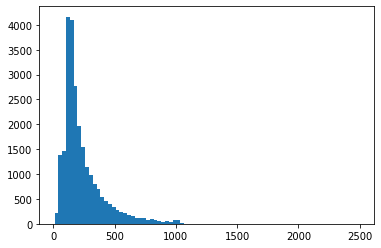

In [8]:
sequence_lengths = [len(sequence) for sequence in train_sequences]
max_len = max(sequence_lengths)
max_len

plt.hist(sequence_lengths, bins=80)
plt.show()

## Pad Sequences  to some length because the dataset should be in rectangular for feeding to tensors

*  all sequences above maxlen will be truncated to that length
*  note: pad_sequences has "pre" and "post" options for both padding and truncation. one may be better than the other!

In [9]:
max_words = 500
train_sequences = sequence.pad_sequences(train_sequences, maxlen=max_words)
test_sequences = sequence.pad_sequences(test_sequences, maxlen=max_words)

## Load the dataset into tensors

In [10]:
train_labels = train_labels.reshape(-1).astype(np.int32)
test_labels = test_labels.reshape(-1).astype(np.int32)
# train_data = tf.data.Dataset.from_tensor_slices((train_sequences, train_labels))
# test_data = tf.data.Dataset.from_tensor_slices((test_sequences, test_labels))

train_data = tf.data.Dataset.from_tensor_slices((train_sequences, train_labels)).shuffle(25000).batch(128, drop_remainder=True)
test_data = tf.data.Dataset.from_tensor_slices((test_sequences, test_labels)).batch(128, drop_remainder=True)

In [11]:
print("Training Dataset Size: ",train_sequences.shape)
print("Test Dataset Size: ",test_sequences.shape)

Training Dataset Size:  (25000, 500)
Test Dataset Size:  (25000, 500)


# Model1

1.   With 10 Epochs
2.   The test accuracy is 50.1%



## Weight Matrix Initializations

In [12]:
W_HH = tf.Variable(tf.random.uniform([1, 100], minval=-0.1, maxval=0.1, dtype=np.float32))
b1 = tf.Variable(np.zeros((100, 1), dtype=np.float32))
W_IH = tf.Variable(tf.random.uniform([1, 20000], minval=-0.1, maxval=0.1, dtype=np.float32))
W_HO = tf.Variable(tf.random.uniform([100, 2], minval=-0.1, maxval=0.1, dtype=np.float32))
c1 = tf.Variable(np.zeros((128, 2), dtype=np.float32))

## Training, Testing define

In [13]:
lr = 0.1
def train_loop(epochs):
    for epoch in range(epochs):
      print("Epoch No: ", epoch)
      for stepCount, (sequence_batch, label_batch) in enumerate(train_data):
          # label_batch = tf.reshape(label_batch, [1])
          train_step(stepCount, sequence_batch, label_batch)
      print("-------------\n")

def test_loop():
    testAcc = []
    for stepCount, (sequence_batch, label_batch) in enumerate(test_data):
        # label_batch = tf.reshape(label_batch, [1])
        testAcc.append(train_step(stepCount, sequence_batch, label_batch, True))

    print("Final Test Accuracy Average: {} ".format(sum(testAcc)/len(testAcc)))


def train_step(step, sequences, labels, testFlag=False):
    with tf.GradientTape() as tape:
        logits = rnn_loop(sequences)
        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=labels))

    if testFlag != True:
      grads = tape.gradient(xent, [W_HH, b1, W_IH, W_HO, c1])

      W_HH.assign_sub(lr * grads[0])
      b1.assign_sub(lr * grads[1])
      W_IH.assign_sub(lr * grads[2])
      W_HO.assign_sub(lr * grads[3])
      c1.assign_sub(lr * grads[4])

    if not step % 50 and testFlag != True:
        print("Steps Completed: ", step)
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, labels), tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))
    
    # For testing the dataset
    if testFlag == True:
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, labels), tf.float32))
        return acc


def rnn_loop(sequences):
    old_state = tf.Variable(np.zeros([100,1], dtype=np.float32))
    seq_onehot = tf.one_hot(sequences, depth=num_words)

    for step in range(max_words):
        x_t = seq_onehot[:,step]
        new_state = rnn_step(old_state, x_t)
        old_state = new_state

    o_t = output_layer(new_state)

    return o_t

def rnn_step(state, x_t):
    at = b1 + tf.matmul(W_HH, state) + tf.matmul(W_IH, tf.transpose(x_t))
    tanFun = tf.nn.tanh(at)
    
    return tanFun


def output_layer(new_state):
    matMul = tf.matmul(tf.transpose(new_state), W_HO)
    ot = c1 + matMul

    return ot

## Running

In [14]:
train_loop(10)
test_loop()

Epoch No:  0
Steps Completed:  0
Loss: 0.6923732161521912 Accuracy: 0.53125
Steps Completed:  50
Loss: 0.6946759223937988 Accuracy: 0.4296875
Steps Completed:  100
Loss: 0.6939346790313721 Accuracy: 0.5078125
Steps Completed:  150
Loss: 0.6942499876022339 Accuracy: 0.46875
-------------

Epoch No:  1
Steps Completed:  0
Loss: 0.6919035911560059 Accuracy: 0.5546875
Steps Completed:  50
Loss: 0.6922401189804077 Accuracy: 0.5625
Steps Completed:  100
Loss: 0.6942858695983887 Accuracy: 0.4453125
Steps Completed:  150
Loss: 0.6931699514389038 Accuracy: 0.53125
-------------

Epoch No:  2
Steps Completed:  0
Loss: 0.6907498836517334 Accuracy: 0.59375
Steps Completed:  50
Loss: 0.6977226734161377 Accuracy: 0.453125
Steps Completed:  100
Loss: 0.6943092346191406 Accuracy: 0.515625
Steps Completed:  150
Loss: 0.6897859573364258 Accuracy: 0.5390625
-------------

Epoch No:  3
Steps Completed:  0
Loss: 0.6922880411148071 Accuracy: 0.5234375
Steps Completed:  50
Loss: 0.6864200830459595 Accuracy: 

# Model2

1.   With 20 Epochs
2.   The test accuracy is 49.8%



## Weight Matrix Initializations

In [15]:
M2_W_HH = tf.Variable(tf.random.uniform([1, 128], minval=-0.5, maxval=0.5, dtype=np.float32))
M2_b1 = tf.Variable(np.zeros((128, 1), dtype=np.float32))
M2_W_IH = tf.Variable(tf.random.uniform([1, 20000], minval=-0.5, maxval=0.5, dtype=np.float32))
M2_W_HO = tf.Variable(tf.random.uniform([128, 2], minval=-0.5, maxval=0.5, dtype=np.float32))
M2_c1 = tf.Variable(np.zeros((128, 2), dtype=np.float32))

## Training, Testing define

In [16]:
lr = 0.1
def train_loop_m2(epochs):
    for epoch in range(epochs):
      print("Epoch No: ", epoch)
      for stepCount, (sequence_batch, label_batch) in enumerate(train_data):
          # label_batch = tf.reshape(label_batch, [1])
          train_step(stepCount, sequence_batch, label_batch)
      print("-------------\n")

def test_loop_m2():
    testAcc = []
    for stepCount, (sequence_batch, label_batch) in enumerate(test_data):
        # label_batch = tf.reshape(label_batch, [1])
        testAcc.append(train_step(stepCount, sequence_batch, label_batch, True))

    print("Final Test Accuracy Average: {} ".format(sum(testAcc)/len(testAcc)))


def train_step_m2(step, sequences, labels, testFlag=False):
    with tf.GradientTape() as tape:
        logits = rnn_loop_m2(sequences)
        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=labels))

    if testFlag != True:
      grads = tape.gradient(xent, [M2_W_HH, M2_b1, M2_W_IH, M2_W_HO, M2_c1])

      M2_W_HH.assign_sub(lr * grads[0])
      M2_b1.assign_sub(lr * grads[1])
      M2_W_IH.assign_sub(lr * grads[2])
      M2_W_HO.assign_sub(lr * grads[3])
      M2_c1.assign_sub(lr * grads[4])

    if not step % 50 and testFlag != True:
        print("Steps Completed: ", step)
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, labels), tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))
    
    # For testing the dataset
    if testFlag == True:
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, labels), tf.float32))
        return acc


def rnn_loop_m2(sequences):
    old_state = tf.Variable(np.zeros([100,1], dtype=np.float32))
    seq_onehot = tf.one_hot(sequences, depth=num_words)

    for step in range(max_words):
        x_t = seq_onehot[:,step]
        new_state = rnn_step_m2(old_state, x_t)
        old_state = new_state

    o_t = output_layer_m2(new_state)

    return o_t

def rnn_step_m2(state, x_t):
    at = M2_b1 + tf.matmul(M2_W_HH, state) + tf.matmul(M2_W_IH, tf.transpose(x_t))
    tanFun = tf.nn.tanh(at)
    
    return tanFun


def output_layer_m2(new_state):
    matMul = tf.matmul(tf.transpose(new_state), M2_W_HO)
    ot = M2_c1 + matMul

    return ot

## Running

In [17]:
train_loop_m2(20)
test_loop_m2()

Epoch No:  0
Steps Completed:  0
Loss: 1.7189579010009766 Accuracy: 0.5390625
Steps Completed:  50
Loss: 2.1390132904052734 Accuracy: 0.4921875
Steps Completed:  100
Loss: 3.5682075023651123 Accuracy: 0.4765625
Steps Completed:  150
Loss: 2.493283271789551 Accuracy: 0.5078125
-------------

Epoch No:  1
Steps Completed:  0
Loss: 3.0763745307922363 Accuracy: 0.390625
Steps Completed:  50
Loss: 2.7556538581848145 Accuracy: 0.4921875
Steps Completed:  100
Loss: 2.0477781295776367 Accuracy: 0.4296875
Steps Completed:  150
Loss: 2.451489210128784 Accuracy: 0.515625
-------------

Epoch No:  2
Steps Completed:  0
Loss: 3.0616815090179443 Accuracy: 0.46875
Steps Completed:  50
Loss: 2.6844284534454346 Accuracy: 0.484375
Steps Completed:  100
Loss: 3.9279706478118896 Accuracy: 0.46875
Steps Completed:  150
Loss: 2.6993408203125 Accuracy: 0.5546875
-------------

Epoch No:  3
Steps Completed:  0
Loss: 2.3693151473999023 Accuracy: 0.46875
Steps Completed:  50
Loss: 1.0983027219772339 Accuracy: 0

# Model3

1.   With 20 Epochs
2.   The test accuracy is 49.8%



## Weight Matrix Initializations

In [ ]:
M3_W_HH = tf.Variable(tf.random.uniform([1, 128], minval=-0.5, maxval=0.5, dtype=np.float32))
M3_b1 = tf.Variable(np.zeros((128, 1), dtype=np.float32))
M3_W_IH = tf.Variable(tf.random.uniform([1, 20000], minval=-0.5, maxval=0.5, dtype=np.float32))
M3_W_HO = tf.Variable(tf.random.uniform([128, 2], minval=-0.5, maxval=0.5, dtype=np.float32))
M3_c1 = tf.Variable(np.zeros((128, 2), dtype=np.float32))

## Training, Testing define

In [ ]:
lr = 0.1
def train_loop_m3(epochs):
    for epoch in range(epochs):
      print("Epoch No: ", epoch)
      for stepCount, (sequence_batch, label_batch) in enumerate(train_data):
          # label_batch = tf.reshape(label_batch, [1])
          train_step(stepCount, sequence_batch, label_batch)
      print("-------------\n")

def test_loop_m3():
    testAcc = []
    for stepCount, (sequence_batch, label_batch) in enumerate(test_data):
        # label_batch = tf.reshape(label_batch, [1])
        testAcc.append(train_step(stepCount, sequence_batch, label_batch, True))

    print("Final Test Accuracy Average: {} ".format(sum(testAcc)/len(testAcc)))


def train_step_m3(step, sequences, labels, testFlag=False):
    with tf.GradientTape() as tape:
        logits = rnn_loop_m3(sequences)
        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=labels))

    if testFlag != True:
      grads = tape.gradient(xent, [M3_W_HH, M3_b1, M3_W_IH, M3_W_HO, M3_c1])

      M3_W_HH.assign_sub(lr * grads[0])
      M3_b1.assign_sub(lr * grads[1])
      M3_W_IH.assign_sub(lr * grads[2])
      M3_W_HO.assign_sub(lr * grads[3])
      M3_c1.assign_sub(lr * grads[4])

    if not step % 50 and testFlag != True:
        print("Steps Completed: ", step)
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, labels), tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))
    
    # For testing the dataset
    if testFlag == True:
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, labels), tf.float32))
        return acc


def rnn_loop_m3(sequences):
    old_state = tf.Variable(np.zeros([100,1], dtype=np.float32))
    seq_onehot = tf.one_hot(sequences, depth=num_words)

    for step in range(max_words):
        x_t = seq_onehot[:,step]
        new_state = rnn_step_m3(old_state, x_t)
        old_state = new_state

    o_t = output_layer_m3(new_state)

    return o_t

def rnn_step_m3(state, x_t):
    at = M2_b1 + tf.matmul(M2_W_HH, state) + tf.matmul(M2_W_IH, tf.transpose(x_t))
    tanFun = tf.nn.tanh(at)
    
    return tanFun


def output_layer_m3(new_state):
    matMul = tf.matmul(tf.transpose(new_state), M2_W_HO)
    ot = M2_c1 + matMul

    return ot

## Running

In [ ]:
train_loop_m2(20)
test_loop_m2()

Epoch No:  0
Steps Completed:  0
Loss: 1.7189579010009766 Accuracy: 0.5390625
Steps Completed:  50
Loss: 2.1390132904052734 Accuracy: 0.4921875
Steps Completed:  100
Loss: 3.5682075023651123 Accuracy: 0.4765625
Steps Completed:  150
Loss: 2.493283271789551 Accuracy: 0.5078125
-------------

Epoch No:  1
Steps Completed:  0
Loss: 3.0763745307922363 Accuracy: 0.390625
Steps Completed:  50
Loss: 2.7556538581848145 Accuracy: 0.4921875
Steps Completed:  100
Loss: 2.0477781295776367 Accuracy: 0.4296875
Steps Completed:  150
Loss: 2.451489210128784 Accuracy: 0.515625
-------------

Epoch No:  2
Steps Completed:  0
Loss: 3.0616815090179443 Accuracy: 0.46875
Steps Completed:  50
Loss: 2.6844284534454346 Accuracy: 0.484375
Steps Completed:  100
Loss: 3.9279706478118896 Accuracy: 0.46875
Steps Completed:  150
Loss: 2.6993408203125 Accuracy: 0.5546875
-------------

Epoch No:  3
Steps Completed:  0
Loss: 2.3693151473999023 Accuracy: 0.46875
Steps Completed:  50
Loss: 1.0983027219772339 Accuracy: 0

# References


1.   https://towardsdatascience.com/a-beginners-guide-on-sentiment-analysis-with-rnn-9e100627c02e
2.   List item

